In [4]:
import torch
import torchvision
import cv2  # Importing OpenCV for resizing

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import urllib.request

import numpy as np
import torch.nn as nn


from sklearn import preprocessing
from sklearn.kernel_approximation import RBFSampler

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [5]:
# Load image
file_path = 'dog.jpg'
if os.path.exists(file_path):
    print('dog.jpg exists')
else:
    url = 'https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg'
    urllib.request.urlretrieve(url, file_path)

In [6]:
# Load image and scale it
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


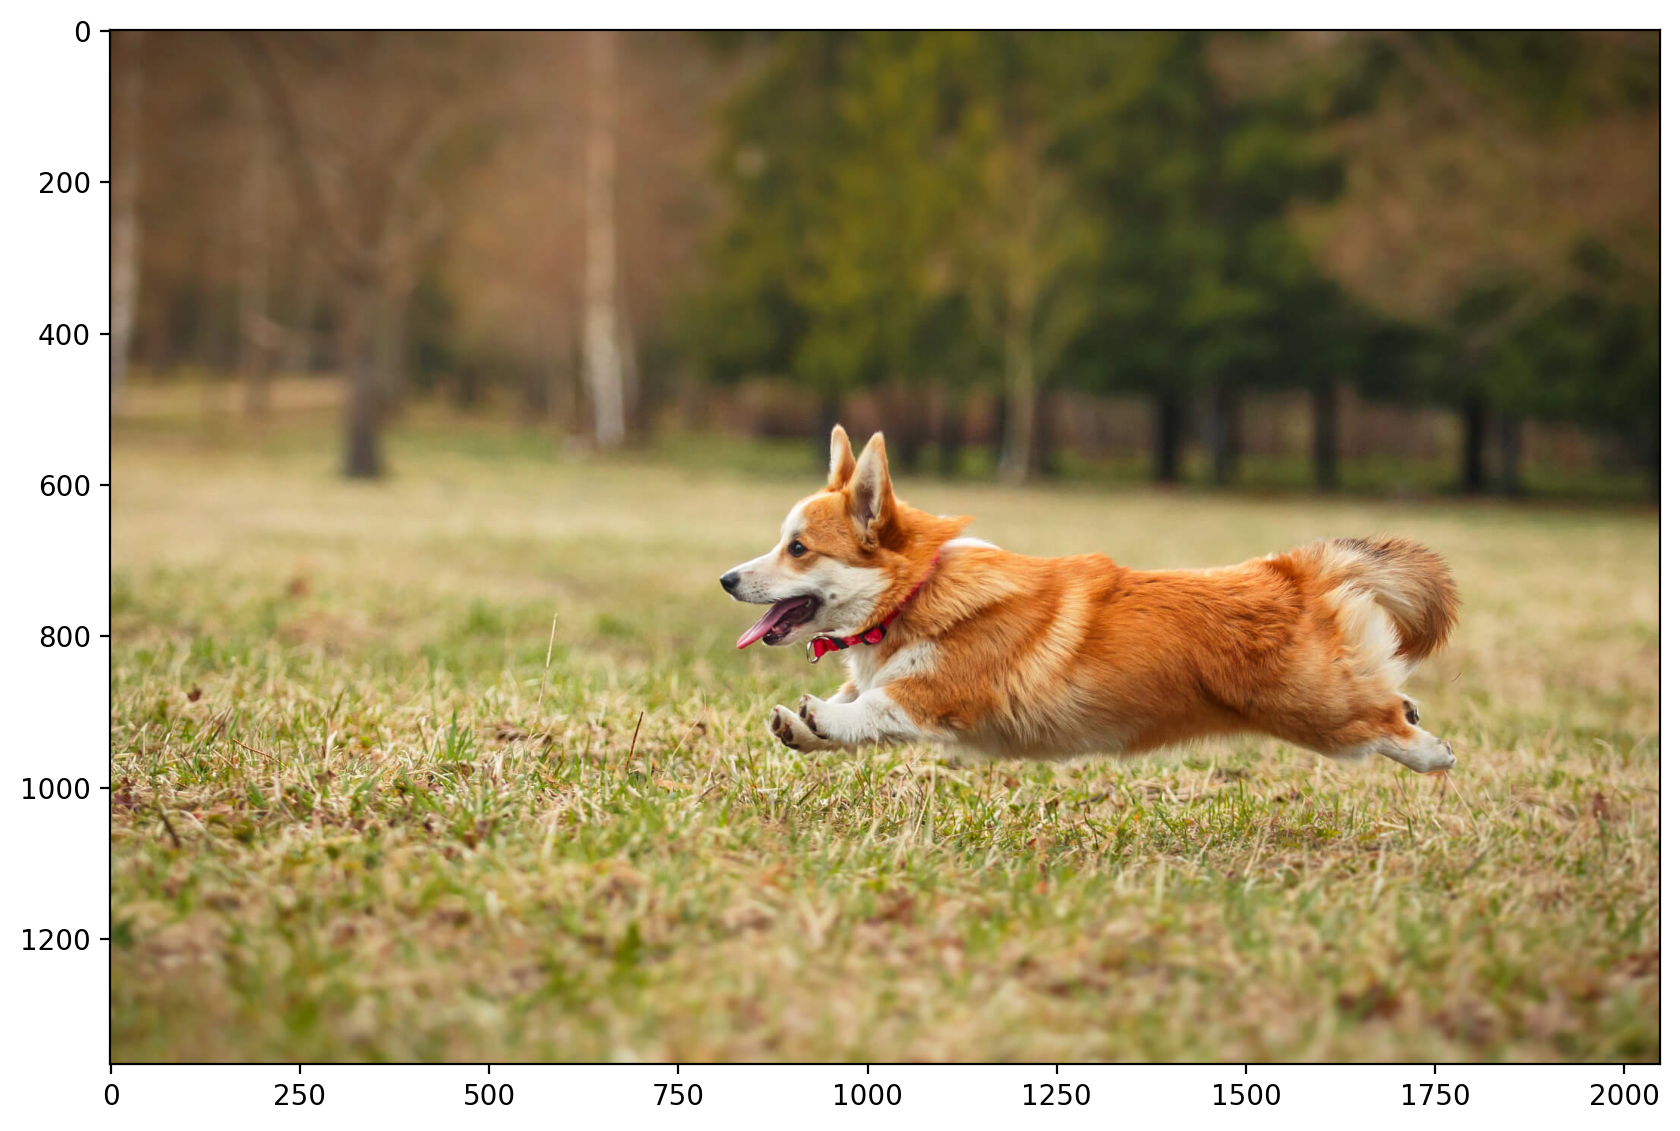

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [8]:
# MinMax scaling the image
scaler = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler

MinMaxScaler()

In [9]:
scaled_img = scaler.transform(img.reshape(-1, 1)).reshape(img.shape)
scaled_img = torch.tensor(scaled_img).float().to(device)
print(scaled_img.shape)
scaled_img

torch.Size([3, 1365, 2048])


tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [10]:
# Cropping the image to a 400x400 patch (High-Resolution)
OriginalImg = torchvision.transforms.functional.crop(scaled_img.cpu(), 600, 800, 400, 400)
print(f"Original high-res image shape: {OriginalImg.shape}")

# Resizing to 200x200 (Low-Resolution)
low_res_img = torch.tensor(cv2.resize(OriginalImg.permute(1, 2, 0).numpy(), (200, 200))).permute(2, 0, 1)
print(f"Low-res image shape: {low_res_img.shape}")

Original high-res image shape: torch.Size([3, 400, 400])
Low-res image shape: torch.Size([3, 200, 200])


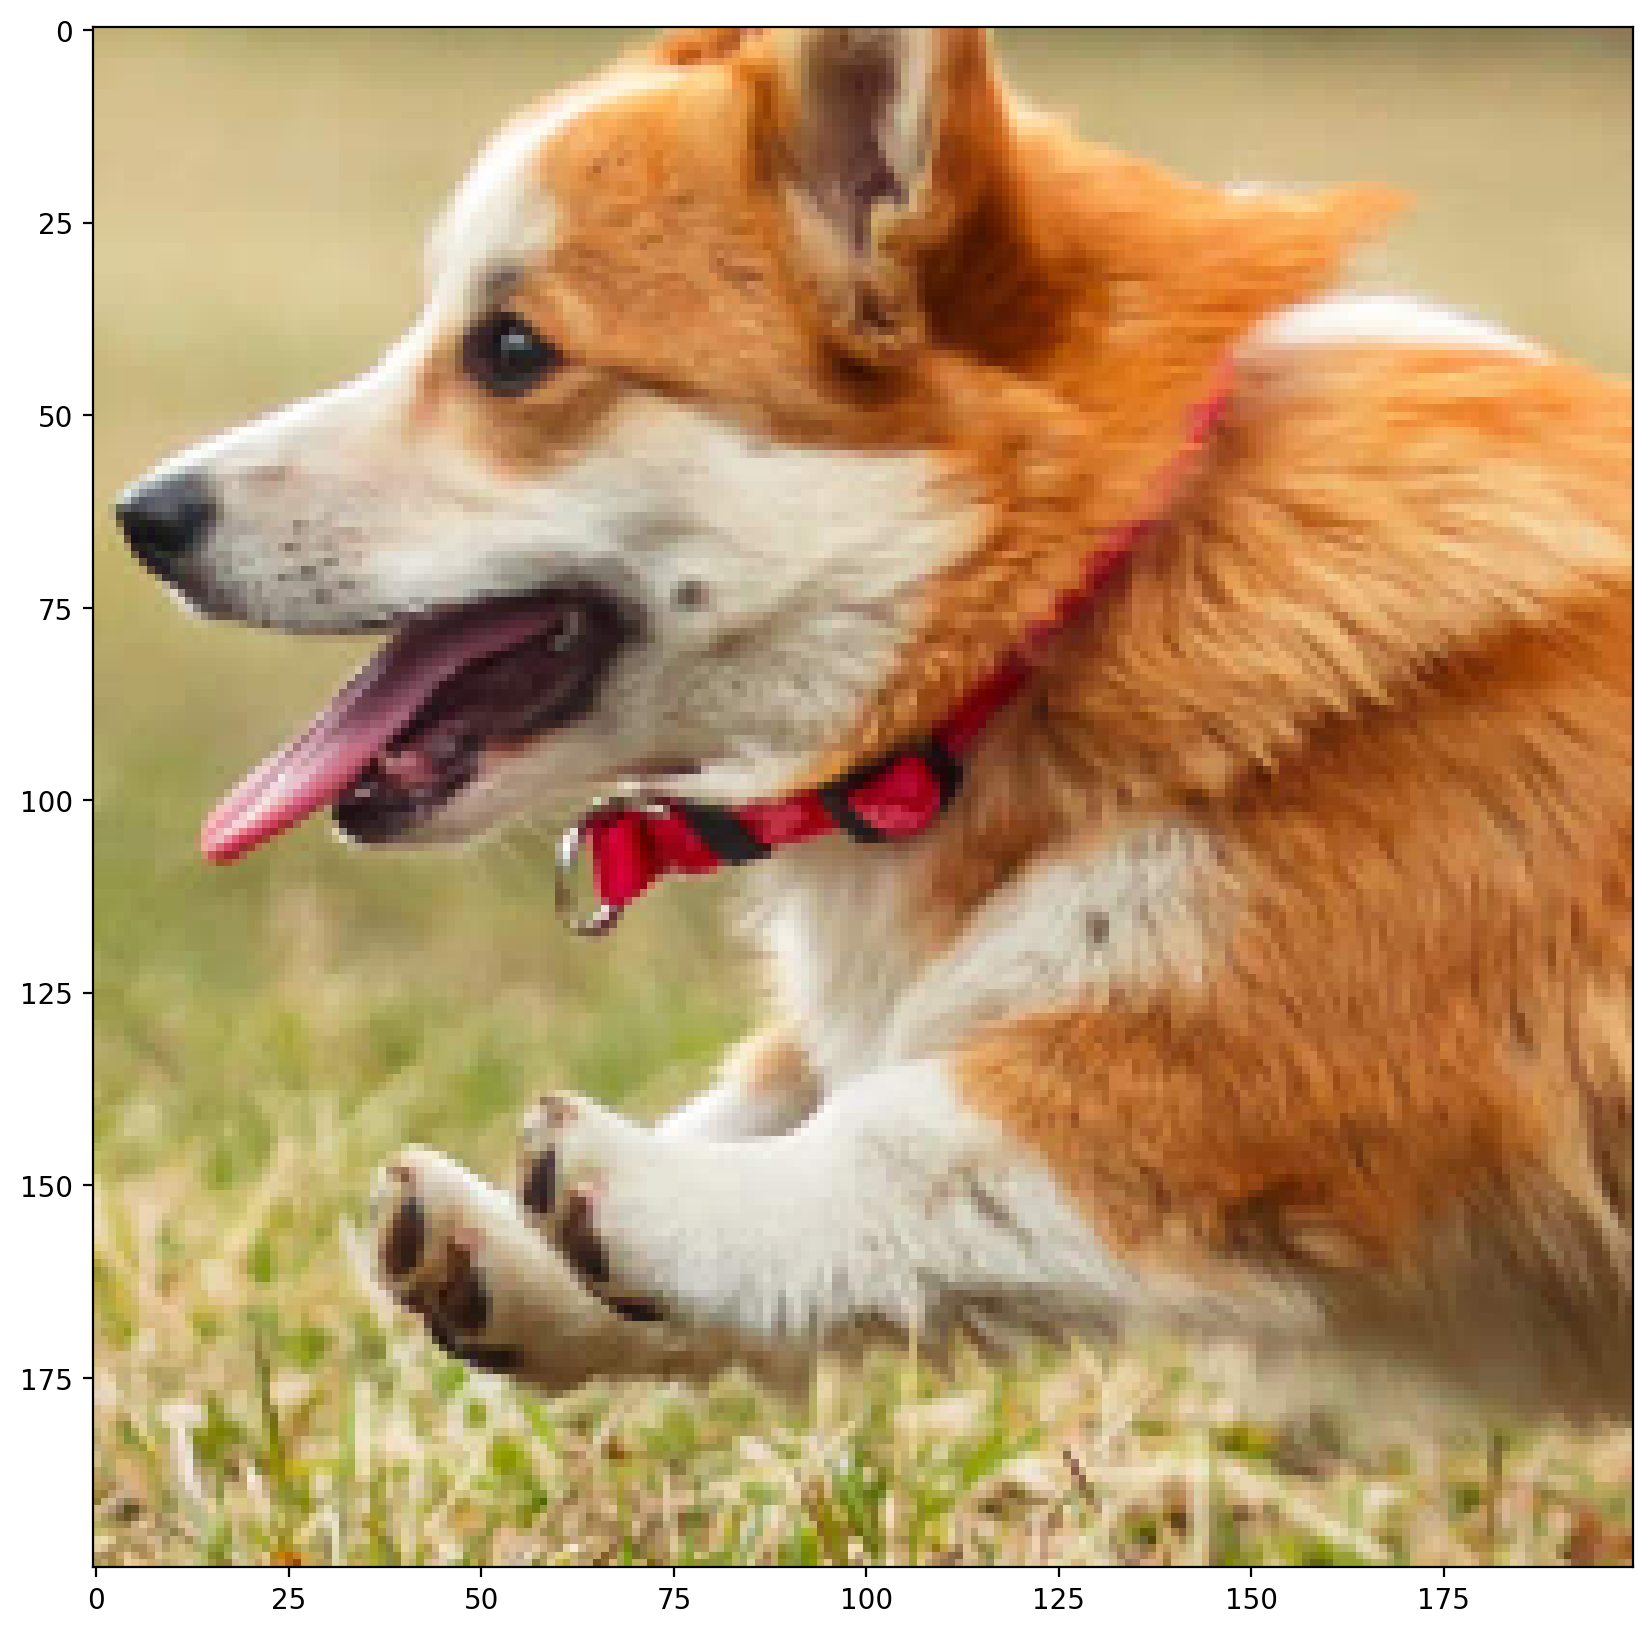

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(rearrange(low_res_img, 'c h w -> h w c').numpy())

In [12]:
# Training the linear model using Random Fourier Features (RFF)
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    num_channels, height, width = img.shape
    height *= scale
    width *= scale

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float().to(device)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [13]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [14]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    print(f"Epoch{epoch} loss: {loss.item():.6f}")
    return loss.item()

In [15]:
def plot_Original_vs_Enhanced_Img(OriginalImg, X_rff_enhanced, net, scale = 1, return_Output = 0):
    """
    OriginalImg: torch.Tensor of shape (num_channels, height, width)
    X_rff_enhanced: torch.Tensor of shape (num_samples, num_features)
    net: torch.nn.Module
    scale: int
    return_Output: int
    return: torch.Tensor of shape (num_channels, scale*height, scale*width)

    """
    num_channels, height, width = OriginalImg.shape

    height *= scale
    width *= scale

    with torch.no_grad():
        outputs = net(X_rff_enhanced)
        enhanced_img = outputs.reshape(num_channels, height, width).to(device)
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax0.set_title(f'Original Image ({height//scale}x{width//scale})')
    ax0.imshow(rearrange(OriginalImg, 'c h w -> h w c').cpu().numpy())

    ax1 = plt.subplot(gs[1])
    ax1.set_title(f'Enhanced Image ({height}x{width})')
    ax1.imshow(enhanced_img.reshape(height,width,num_channels).cpu().detach().numpy())

    fig.suptitle('Original vs Enhanced Image',fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()
    if(return_Output == 1):
        return enhanced_img

In [16]:
# Super-resolution function (doublePixels)
def doublePixels(image, num_features, sigma=0.04, lr=0.02, epochs=1000, device='cpu'):
    
    """ image: torch.Tensor of shape (num_channels, height, width)
        num_features: int
        sigma: float
        lr: float
        epochs: int
        device: str
        """

    import gc
    from sklearn import preprocessing
    from sklearn.kernel_approximation import RBFSampler
    
    X, Y = create_coordinate_map(image)
    Y = Y.to(device)

    # Scale coordinates
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X.cpu())
    scaled_X = torch.tensor(scaler.transform(X.cpu())).float().to(device)

    # RFF
    rff = RBFSampler(n_components=num_features, gamma=1 / (2 * sigma**2), random_state=42)
    X_rff = torch.tensor(rff.fit_transform(scaled_X.cpu().numpy())).float().to(device)

    # Training the model
    net = LinearModel(X_rff.shape[1], image.shape[0]).to(device)
    train(net, lr, X_rff, Y, epochs)

  
    # Generating enhanced image with 2x resolution
    X_, Y_ = create_coordinate_map(image, scale=2)

    scaler = preprocessing.MinMaxScaler(feature_range= (-1,1)).fit(X_.cpu())
    scaled_X_ = torch.tensor(scaler.transform(X_.cpu())).float().to(device)

    X_rff = torch.tensor(rff.transform(scaled_X_.cpu().numpy())).float().to(device)

    print("\nComparison Between Low Resolution Image and Enhanced Image:")
    EnImg = plot_Original_vs_Enhanced_Img(image, X_rff, net, scale = 2, return_Output = 1)
    del net, X_rff, X_, Y_, scaled_X_, scaler
    gc.collect()

    return EnImg

Epoch 0 loss: 0.371132
Epoch 100 loss: 0.003282
Epoch 200 loss: 0.003082
Epoch 300 loss: 0.003028
Epoch 400 loss: 0.003000
Epoch 500 loss: 0.002982
Epoch 600 loss: 0.002969
Epoch 700 loss: 0.002960
Epoch 800 loss: 0.002952
Epoch 900 loss: 0.002945
Epoch999 loss: 0.002940

Comparison Between Low Resolution Image and Enhanced Image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14710386..1.0197443].


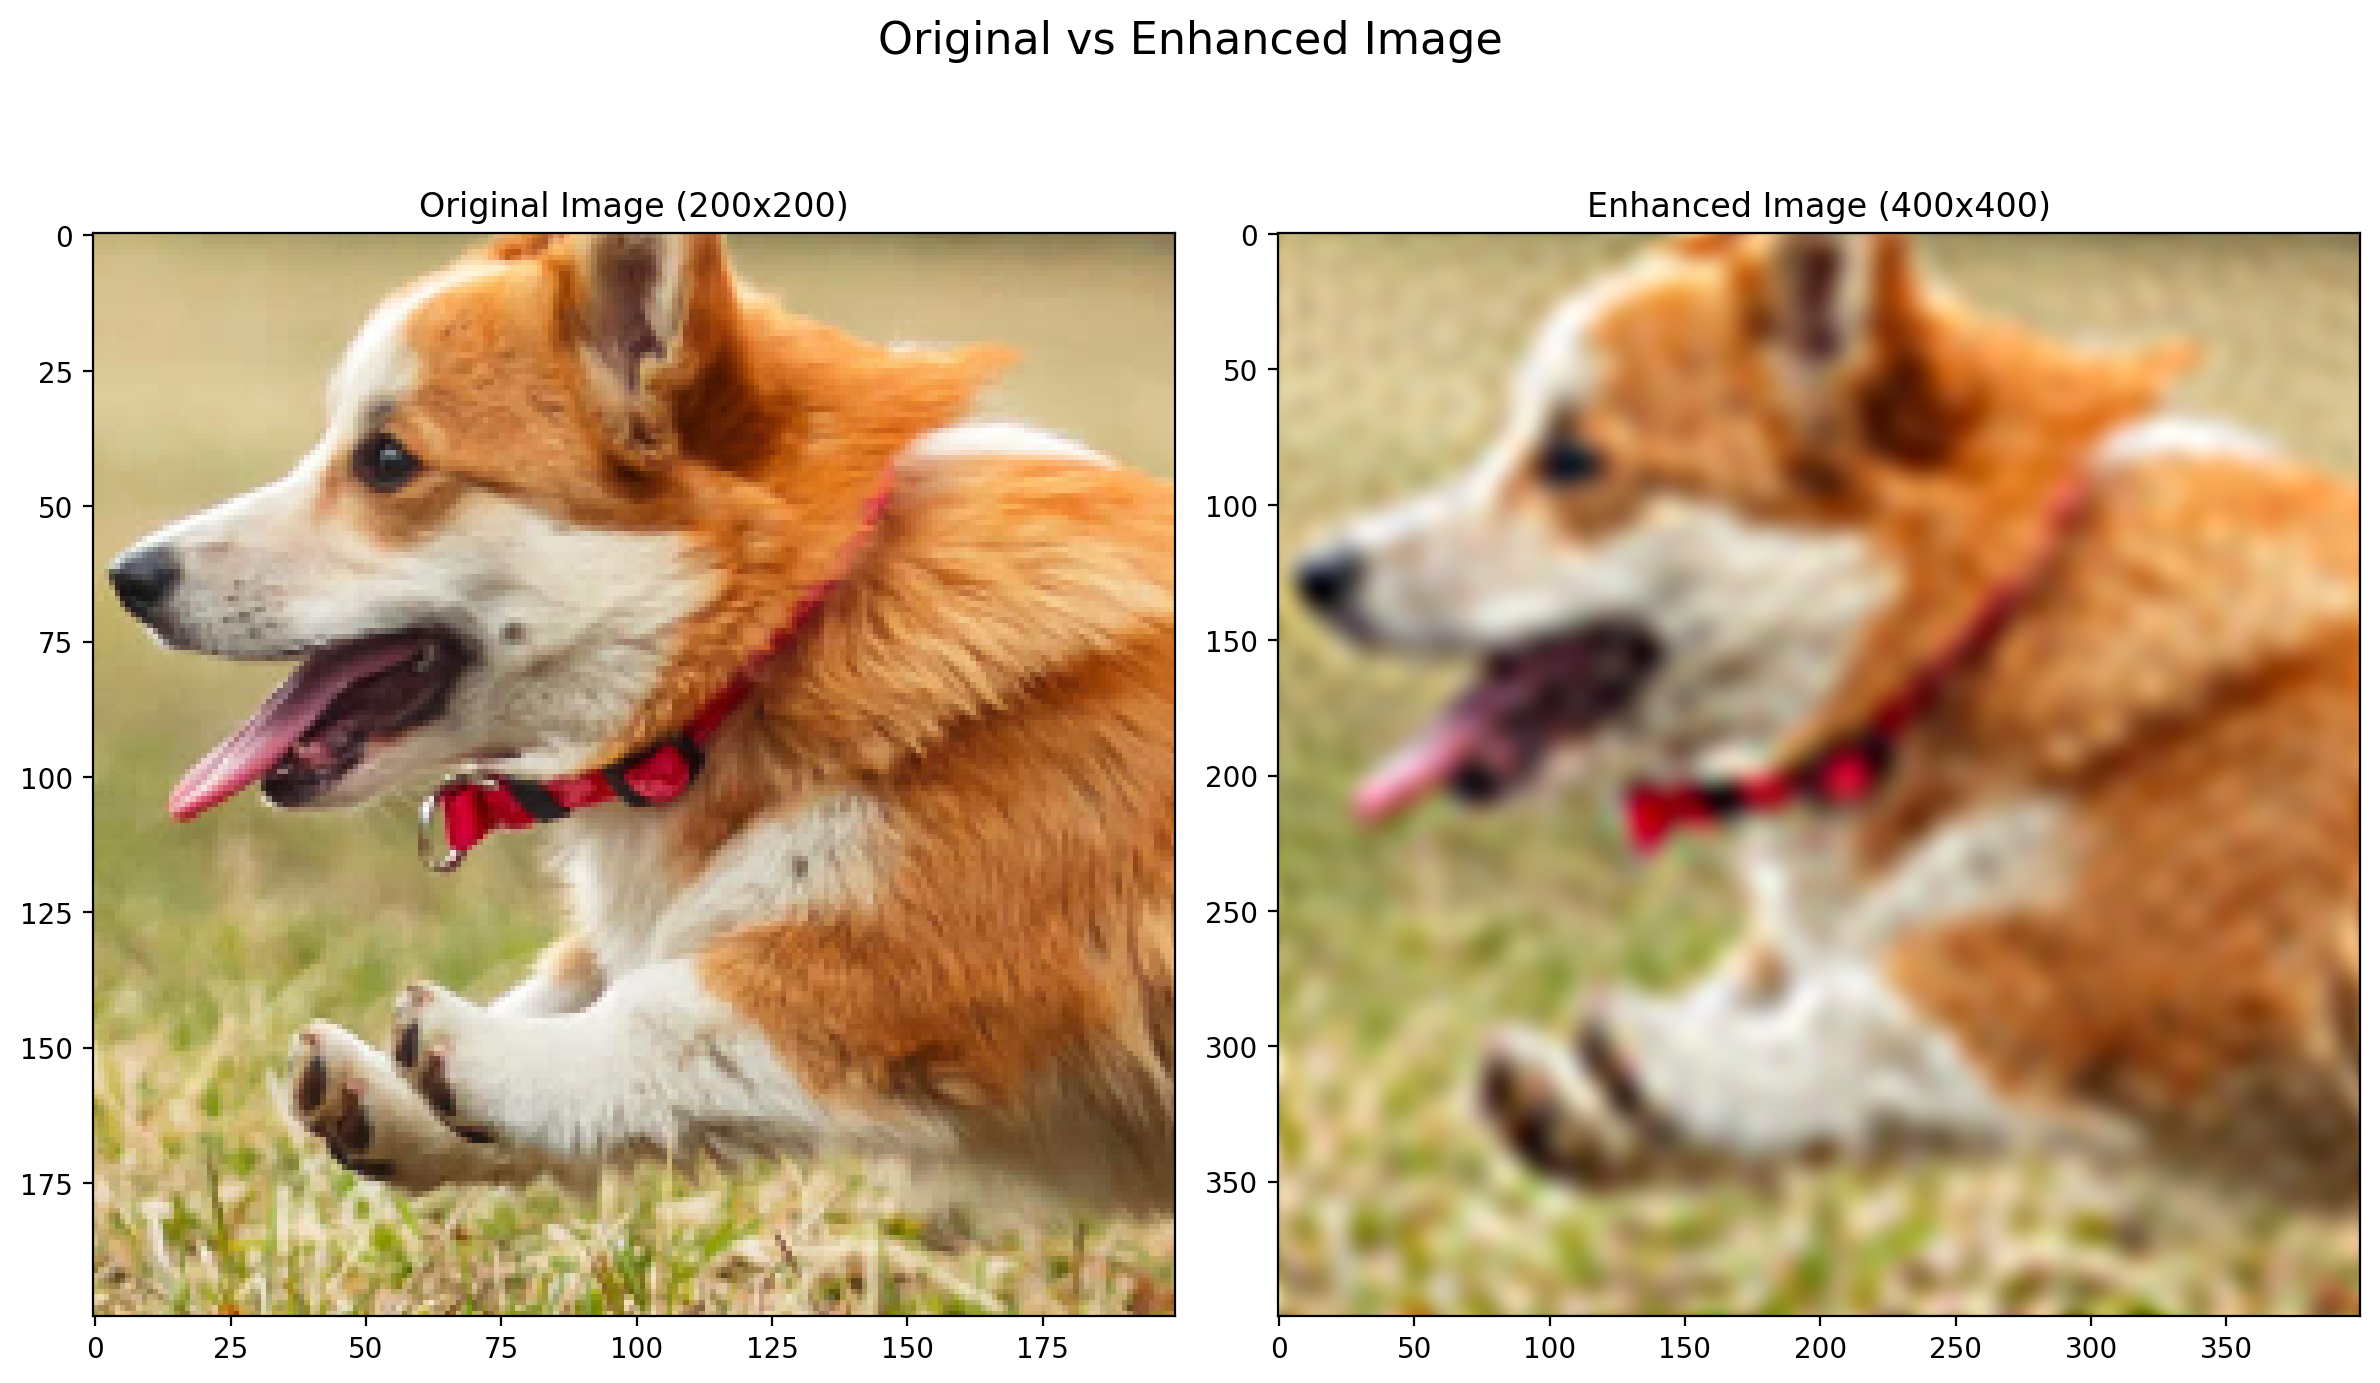

In [17]:
# Perform super-resolution and compare with original
enhanced_img = doublePixels(low_res_img, 10000, sigma=0.04, epochs=1000, lr=0.01)

In [18]:
def calRMSE_and_PSNR(img1,img2):
    """
    img1: torch.Tensor of shape (num_channels, height, width)
    img2: torch.Tensor of shape (num_channels, height, width)

    return: tuple of float and float
    """
    rmse = torch.sqrt(torch.mean((img1 - img2) ** 2))
    psnr = 20 * torch.log10(1.0 / rmse)
    return rmse.item(), psnr.item()

In [19]:
enhanced_img = enhanced_img.to(device)
rmse, psnr = calRMSE_and_PSNR(OriginalImg, enhanced_img)
print("RMSE: ", rmse, "\nPSNR: ", psnr)

RMSE:  0.3112381398677826 
PSNR:  10.138143539428711
